In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
%matplotlib inline

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40063 instead
  warnings.warn(


In [3]:
def global_mean(ds,weights):
    """ Area weighted global mean of a DataArray"""
    # Check the shapes match
    assert ds.shape[-2:] == weights.shape, 'Shape mismatch in global_mean'
    assert ds.dims[-2:] == weights.dims, 'Coordinate mismatch in global_mean'
    dims = weights.dims
    if (weights[dims[0]]==ds[dims[0]]).all() and (weights[dims[1]]==ds[dims[1]]).all():
        ds_w = ds.weighted(weights)
    elif np.allclose(weights[dims[0]].data,ds[dims[0]].data) and np.allclose(weights[dims[1]].data,ds[dims[1]].data):
        ds_w = ds.weighted(weights.reindex_like(ds, method='nearest', tolerance=1e-4))
        warnings.warn("Non exact grid match")
    else:
        raise ValueError("Grid mismatch")
    return ds_w.mean(dims)

def annual_mean(ds, original_time_axis=False):
    """ Properly month length weighted annual mean of a DataArray"""
    if not ds.time.dt.month[0] == 1:
        raise ValueError("Data does not start with January")
    if not ds.time.dt.month[1] == 2:
        raise ValueError("Non-monthly data")
    # Process only complete years
    nmon = 12*(len(ds.time)//12)
    month_length = ds.time.dt.days_in_month[:nmon]
    # Eventually use weighted ??? https://github.com/pydata/xarray/issues/3937
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    ann_mean = (ds[:nmon]*weights).groupby('time.year').sum(dim='time',min_count=1)
    if original_time_axis:
        ann_mean = ann_mean.assign_coords({'year':ds[:nmon].time.groupby('time.year').mean(dim='time')})
    return ann_mean

In [4]:
archive = Path('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814')
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
files = sorted(archive.glob('output*/ocean/ocean-3d-salt-1monthly-mean-ym_*'))
salt = xr.open_mfdataset(files, decode_times=time_coder, decode_timedelta=False).salt

areacello = xr.open_dataset(archive / 'output000/ocean/ocean-2d-area_t.nc').area_t.squeeze()

/jobfs/141311400.gadi-pbs/ipykernel_2241987/346257665.py:6: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  areacello = xr.open_dataset(archive / 'output000/ocean/ocean-2d-area_t.nc').area_t.squeeze()


In [5]:
salt_med = salt[:,:,197:214,275:316].compute()

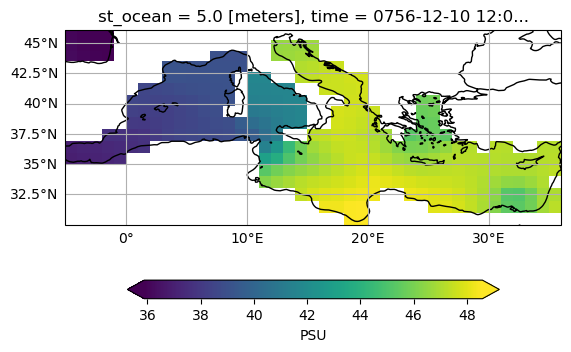

In [6]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=["bottom", 'left'])
salt_med[-1,0].plot(ax=ax,
                 cbar_kwargs={'extend':'both', 'orientation':'horizontal', 'shrink':0.75, 'label':'PSU'})

In [7]:
salt_e_med = salt_med[:,:,:,20:].compute()
salt_w_med = salt_med[:,:,:,:20].compute()

salt_med_ann = annual_mean(salt_med).compute()
salt_med_ave = global_mean(salt_med_ann, areacello[197:214,275:316]).compute()
salt_e_med_ann = annual_mean(salt_e_med).compute()
salt_e_med_ave = global_mean(salt_e_med_ann, areacello[197:214,295:316]).compute()
salt_w_med_ann = annual_mean(salt_w_med).compute()
salt_w_med_ave = global_mean(salt_w_med_ann, areacello[197:214,275:295]).compute()

Text(0.5, 1.0, 'Annual mean surface salinity')

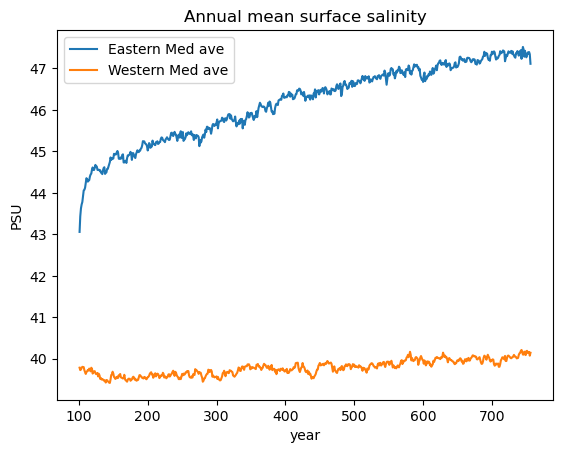

In [8]:
fig, axes = plt.subplots()
salt_e_med_ave[:,0].plot(label='Eastern Med ave')
salt_w_med_ave[:,0].plot(label='Western Med ave')
axes.legend()
axes.set_ylabel('PSU')
axes.set_title('Annual mean surface salinity')

Text(0.5, 1.0, 'E Mediterranean average salinity')

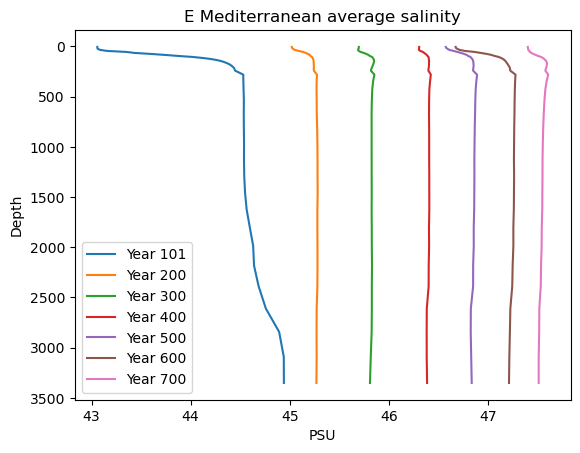

In [9]:
fig, axes = plt.subplots()
(salt_e_med_ave)[0].plot(y='st_ocean', label='Year 101')
(salt_e_med_ave)[99].plot(y='st_ocean', label='Year 200')
(salt_e_med_ave)[199].plot(y='st_ocean', label='Year 300')
(salt_e_med_ave)[299].plot(y='st_ocean', label='Year 400')
(salt_e_med_ave)[399].plot(y='st_ocean', label='Year 500')
(salt_e_med_ave)[499].plot(y='st_ocean', label='Year 600')
(salt_e_med_ave)[599].plot(y='st_ocean', label='Year 700')
axes.invert_yaxis()
axes.set_ylabel('Depth')
axes.set_xlabel('PSU')
axes.legend()
axes.set_title('E Mediterranean average salinity')

Text(0.5, 1.0, 'W Mediterranean average salinity')

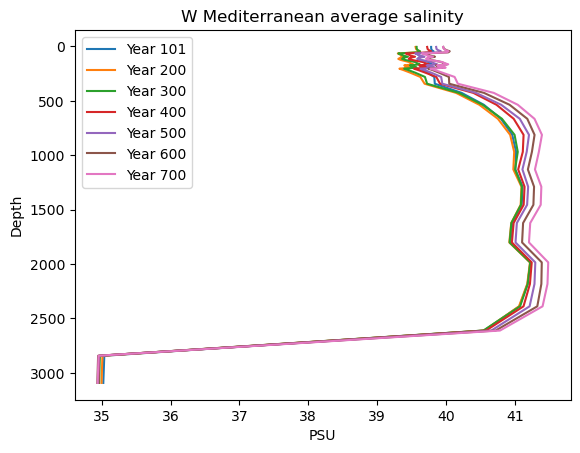

In [10]:
fig, axes = plt.subplots()
(salt_w_med_ave)[0].plot(y='st_ocean', label='Year 101')
(salt_w_med_ave)[99].plot(y='st_ocean', label='Year 200')
(salt_w_med_ave)[199].plot(y='st_ocean', label='Year 300')
(salt_w_med_ave)[299].plot(y='st_ocean', label='Year 400')
(salt_w_med_ave)[399].plot(y='st_ocean', label='Year 500')
(salt_w_med_ave)[499].plot(y='st_ocean', label='Year 600')
(salt_w_med_ave)[599].plot(y='st_ocean', label='Year 700')
axes.invert_yaxis()
axes.set_ylabel('Depth')
axes.set_xlabel('PSU')
axes.legend()
axes.set_title('W Mediterranean average salinity')

In [11]:
salt_max = salt.max(('st_ocean', 'yt_ocean', 'xt_ocean')).compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 32.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 0, 'Year')

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/nc_time_axis/__init__.py:376: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.datetime(


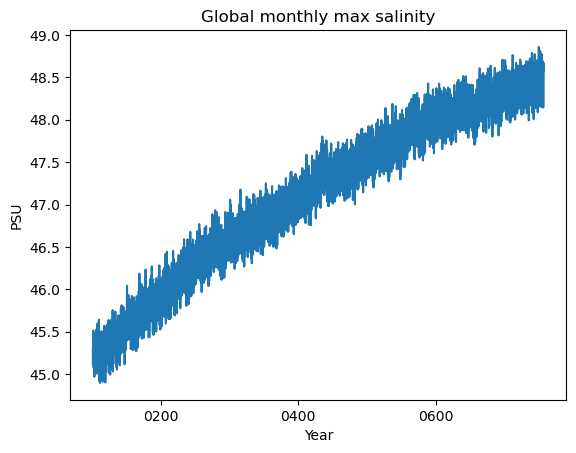

In [12]:
fig, axes = plt.subplots()
salt_max.plot()
# salt_med_ave[
axes.set_ylabel('PSU')
axes.set_title('Global monthly max salinity')
axes.set_xlabel('Year')

Text(0, 0.5, 'Depth')

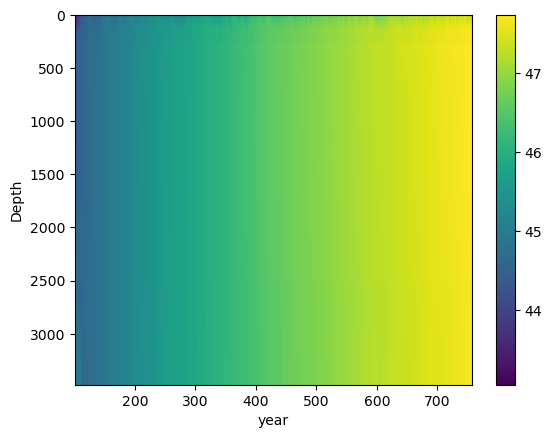

In [13]:
fig, axes = plt.subplots()
# (salt_e_med_ave-salt_e_med_ave[0,:42]).plot(x='year')
(salt_e_med_ave)[:,:42].plot(x='year')
axes.invert_yaxis()
axes.set_ylabel('Depth')

Text(0, 0.5, 'Depth')

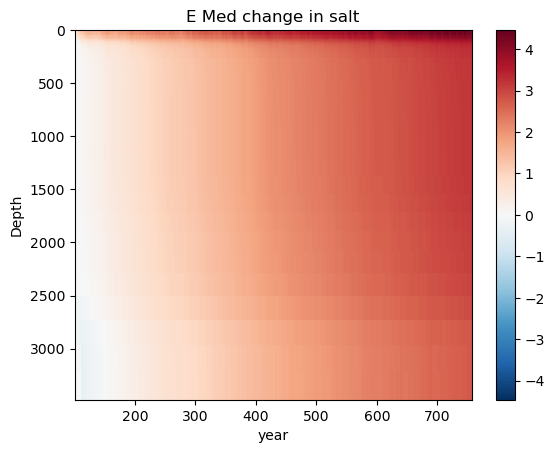

In [14]:
fig, axes = plt.subplots()
(salt_e_med_ave-salt_e_med_ave[0,:42]).plot(x='year')
axes.invert_yaxis()
axes.set_title('E Med change in salt')
axes.set_ylabel('Depth')

Text(0, 0.5, 'Depth')

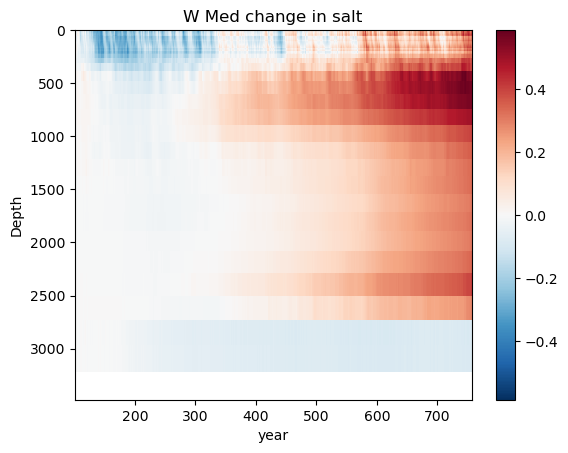

In [15]:
fig, axes = plt.subplots()
((salt_w_med_ave)[:,:42]-salt_w_med_ave[0,:42]).plot(x='year')
axes.invert_yaxis()
axes.set_title('W Med change in salt')
axes.set_ylabel('Depth')